In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, AveragePooling3D, BatchNormalization, GlobalAveragePooling3D, Concatenate, Dropout, Activation, concatenate
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from numpy.core.records import array
import pandas as pd
import os
import librosa
from scipy import ndimage
from tensorflow.python.keras.models import Model
import math

In [3]:
checkpoint_weight_path = 'models/weights.best_3cnn6.hdf5'
weight_path = 'models/weights.basic_3cnn6.hdf5'
model_name = 'models/3cnn_model1.h5'
logs_path = './logs/3cnn5/'
num_epochs = 50
num_batch_size = 2

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img, depth=64, width=128, height=128):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = depth
    desired_width = width
    desired_height = height
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[2]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # # Rotate
    # img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor,height_factor,width_factor, ), order=1)
    return img

def preprocess_volume(volume, depth=64, width=128, height=128):
    volume = np.array(volume)
    volume = volume.reshape(volume.shape[:3])
    # volume = normalize(volume)
    volume = resize_volume(volume, depth, width, height)
    volume = volume.reshape(volume.shape + (1,))
    return volume

def get_vertices(label_dataframe: pd.DataFrame):
    return {
        "xmax": max(label_dataframe.xmax),
        "xmin": min(label_dataframe.xmin),
        "ymax": max(label_dataframe.ymax),
        "ymin": min(label_dataframe.ymin),
        "zmax": max(label_dataframe.z),
        "zmin": min(label_dataframe.z)
    }

def get_original_case(df: pd.DataFrame, data_from, category):
    the_one = df.loc[(df["category"] == category) & (df["number"] == data_from) & (df["type"] == "normal")].reset_index()
    if the_one.shape[0] == 1:
        return the_one["number"][0]
    else:
        the_one = df.loc[(df["category"] == category) & (df["number"] == data_from)].reset_index()
        return get_original_case(df=df, data_from=the_one["from"][0], category=category)


fulldatasetpath = r'./images/'

metadata = pd.read_csv(r'./metadatas/matadata_new.csv')

data = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath), str(row["category"]), 'Case ' + str(row["number"]))
    mri = []
    from_index = get_original_case(df=metadata, data_from=row["from"], category=row["category"])
    label_folder = os.path.join(os.path.abspath(fulldatasetpath), str(row["category"]), 'Case ' + str(from_index))

    posterior_label = []
    left_label = []
    right_label = []


    for i in range(1, 29):
        im = image.load_img(file_name + r'/' + str(i) + r'.jpg', color_mode = 'grayscale')
        im = img_to_array(im)
        
        xtree = et.parse(label_folder + "/outputs/"+ str(i) + ".xml")
        xroot = xtree.getroot()
        xoutput = xroot.iter('item')

        for node in xoutput:
            name = node.find('name').text.replace(" ", "")
            bndbox = node.find("bndbox")
            label = {"name": node.find('name').text.replace(" ", ""),
                    "z": i,
                    "xmin": int(bndbox.find("xmin").text) if row["type"] != "flip" else im.shape[1] - int(bndbox.find("xmax").text),
                    "ymin": int(bndbox.find("ymin").text)  ,
                    "xmax": int(bndbox.find("xmax").text) if row["type"] != "flip" else im.shape[1] - int(bndbox.find("xmin").text), 
                    "ymax": int(bndbox.find("ymax").text)}
            if name == "posterior" or name == "Posterior":
                posterior_label.append(label)
            elif name == "right" or name == "Right":
                left_label.append(label)
            elif name == "left" or name == "Left":
                right_label.append(label)

        mri.append(im)

    post_dataframe = pd.DataFrame(posterior_label)
    post_vertices = get_vertices(post_dataframe)

    left_dataframe = pd.DataFrame(left_label)
    left_vertices = get_vertices(left_dataframe)

    right_dataframe = pd.DataFrame(right_label)
    right_vertices = get_vertices(right_dataframe)

    # collect post
    mri_post = []
    for m in mri[post_vertices["zmin"]: post_vertices["zmax"]]:
        mri_post.append(m[post_vertices["ymin"]:post_vertices["ymax"],
                            post_vertices["xmin"]: post_vertices["xmax"]])

    # collect right
    mri_right = []
    for m in mri[right_vertices["zmin"]: right_vertices["zmax"]]:
        mri_right.append(m[right_vertices["ymin"]:right_vertices["ymax"],
                            right_vertices["xmin"]: right_vertices["xmax"]])

    # collect post
    mri_left = []
    for m in mri[left_vertices["zmin"]: left_vertices["zmax"]]:
        mri_left.append(m[left_vertices["ymin"]:left_vertices["ymax"],
                            left_vertices["xmin"]: left_vertices["xmax"]])
    
    mri_post = preprocess_volume(mri_post)
    mri_left = preprocess_volume(mri_left, width=64)
    mri_right = preprocess_volume(mri_right, width=64)
    # plt.imshow(mri_left[0], cmap="gray")
    # plt.show()
    # print(mri_post.shape)
    # print(mri_left.shape)
    # print(mri_right.shape)
    PT = row["PT"]
    APTT = row["APTT"]
    info = [int(row["age"]), 
            (row["sex"] == "M"), 
            (row["sex"] != "M"), 
            math.isnan(PT), 
            float(PT) if not math.isnan(PT) else float(-1), 
            math.isnan(APTT), 
            float(APTT) if not math.isnan(APTT) else float(-1)]
    data.append([mri_post, mri_right, mri_left, info, row["category"], row["isReal"]])


dataframe = pd.DataFrame(data, columns=["mri_post", "mri_right", "mri_left", "info", "category", "isReal"])
print('Finished data extraction from ', len(dataframe), ' files')

Finished data extraction from  76  files


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# # split the dataset 
train, test = train_test_split(dataframe, test_size=0.2)
# train, validation = train_test_split(train, test_size=0.2, random_state=42)
le = LabelEncoder()

post_train_X = np.array(train.mri_post.tolist())
right_train_X = np.array(train.mri_right.tolist())
left_train_X = np.array(train.mri_left.tolist())
info_train_x = np.array(train["info"].tolist()).astype(np.float32)
train_y = to_categorical(le.fit_transform(train.category.tolist())) 

post_test_X = np.array(test.mri_post.tolist())
right_test_X = np.array(test.mri_right.tolist())
left_test_X = np.array(test.mri_left.tolist())
info_test_X = np.array(test["info"].tolist()).astype(np.float32)
test_y = to_categorical(le.fit_transform(test.category.tolist()))

# print(train.category.tolist())
# print(train_y)
train_count = np.count_nonzero(train_y, axis=0)
test_count = np.count_nonzero(test_y, axis=0)
print("Train count[Af, TS]:", train_count)
print("Test count[Af, TS]:", test_count)

Train count[Af, TS]: [33 27]
Test count[Af, TS]: [7 9]


In [5]:
# print(test_y)
# post_validation_X = np.array(validation.mri_post.tolist())
# right_validation_X = np.array(validation.mri_right.tolist())
# left_validation_X = np.array(validation.mri_left.tolist())
# validation_y = to_categorical(le.fit_transform(validation.category.tolist())) 

# print(post_test_X.shape)
# print(right_test_X.shape)
# print(test_y.shape)

# a, num_channels, num_rows, num_columns, b = x_train.shape

# x_train = x_train.reshape(x_train.shape[0],num_channels, num_rows, num_columns, 1)
# x_test = x_test.reshape(x_test.shape[0],num_channels, num_rows, num_columns, 1)

num_labels = train_y.shape[1]
filter_size = 2
filter1 = 5
filter2 = 5
filter3 = 5

def get_info_model(input_size=7):
    inputs = keras.Input(input_size)
    x = Dense(units=100, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(units=100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    model = keras.Model(inputs, x)
    return model

def get_mini_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""
    inputs = keras.Input((depth, height, width, 1))
    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = AveragePooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = AveragePooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # x = GlobalAveragePooling3D()(x)
    # x = Dense(units=512, activation="relu")(x)
    # x = Dropout(0.3)(x)
    x = Flatten()(x)
    # outputs = Dense(units=4, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, x)
    return model

def get_3model():
    post_model = get_mini_model()
    right_model = get_mini_model(width=64)
    left_model = get_mini_model(width=64)

    x  = concatenate([post_model.output, right_model.output, left_model.output])
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_labels, activation='softmax')(x)
    model = keras.Model([post_model.input, right_model.input, left_model.input], x)
    opt = keras.optimizers.Adam(learning_rate=0.00005)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return model

def get_4model():
    post_model = get_mini_model()
    right_model = get_mini_model(width=64)
    left_model = get_mini_model(width=64)
    info_model = get_info_model()

    x  = concatenate([post_model.output, right_model.output, left_model.output, info_model.output])
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_labels, activation='softmax')(x)
    model = keras.Model([post_model.input, right_model.input, left_model.input, info_model.input], x)
    opt = keras.optimizers.Adam(learning_rate=0.00005)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return model

In [6]:
# Normal
# model = keras.Model([post_model.input, right_model.input, left_model.input], x)

# Compile the model
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# model.summary()
# model.save(model_name)
# score = model.evaluate([post_test_X, right_test_X, left_test_X], test_y, verbose=1, batch_size=num_batch_size)

# checkpointer = ModelCheckpoint(filepath=checkpoint_weight_path, 
#                                verbose=1, save_best_only=True)
# # monitor = RemoteMonitor()
# tbCallBack = TensorBoard(log_dir=logs_path,
#                  histogram_freq=0,
#                  write_graph=True, 
#                  write_grads=True, 
#                  write_images=True,
#                  embeddings_freq=0, 
#                  embeddings_layer_names=None, 
#                  embeddings_metadata=None)
# # validation_data=([post_test_X, right_test_X, left_test_X], test_y)
# history = model.fit([post_train_X, right_train_X, left_train_X], train_y, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[checkpointer, tbCallBack], verbose=1)
# model.save_weights(filepath=weight_path)
# score = model.evaluate([post_test_X, right_test_X, left_test_X], test_y, verbose=1, batch_size=num_batch_size)

# 5-Fold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

print(kf)
three_history_list = []
four_history_list = []
three_models = []
four_models = []
three_score = []
four_score = []
for train_index, test_index in kf.split(train_y):
    model = None
    model = get_4model()
    
    history = model.fit([post_train_X[train_index], right_train_X[train_index], left_train_X[train_index], info_train_x[train_index]], 
                        train_y[train_index], 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=([post_train_X[test_index], right_train_X[test_index], left_train_X[test_index], info_train_x[test_index]], train_y[test_index]), verbose=1)
    four_history_list.append(history)
    four_models.append(model)
    # model.save_weights(filepath=weight_path)
    score = model.evaluate([post_test_X, right_test_X, left_test_X, info_test_X], test_y, verbose=1, batch_size=num_batch_size)
    three_score.append(score)


    model = get_3model()
    history = model.fit([post_train_X[train_index], right_train_X[train_index], left_train_X[train_index]], 
                        train_y[train_index], 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=([post_train_X[test_index], right_train_X[test_index], left_train_X[test_index]], train_y[test_index]), verbose=1)
    three_history_list.append(history)
    three_models.append(model)
    score = model.evaluate([post_test_X, right_test_X, left_test_X], test_y, verbose=1, batch_size=num_batch_size)
    four_score.append(score)
    
    train_count = np.count_nonzero(train_y[train_index], axis=0)
    test_count = np.count_nonzero(train_y[test_index], axis=0)
    print("Train count[Af, TS]:", train_count)
    print("Validation count[Af, TS]:", test_count)

KFold(n_splits=5, random_state=None, shuffle=False)
Epoch 1/50
24/24 [==============================] - 17s 248ms/step - loss: 0.7327 - accuracy: 0.5625 - val_loss: 0.6776 - val_accuracy: 0.8333
Epoch 2/50
24/24 [==============================] - 5s 228ms/step - loss: 0.5016 - accuracy: 0.7917 - val_loss: 0.5651 - val_accuracy: 0.8333
Epoch 3/50
24/24 [==============================] - 6s 232ms/step - loss: 0.5102 - accuracy: 0.7292 - val_loss: 0.4899 - val_accuracy: 0.8333
Epoch 4/50
24/24 [==============================] - 6s 230ms/step - loss: 0.3500 - accuracy: 0.8958 - val_loss: 0.4199 - val_accuracy: 0.8333
Epoch 5/50
24/24 [==============================] - 6s 234ms/step - loss: 0.3166 - accuracy: 0.8958 - val_loss: 0.3591 - val_accuracy: 0.9167
Epoch 6/50
24/24 [==============================] - 6s 230ms/step - loss: 0.1027 - accuracy: 0.9583 - val_loss: 0.4105 - val_accuracy: 0.7500
Epoch 7/50
24/24 [==============================] - 5s 229ms/step - loss: 0.2942 - accuracy: 0.

8/8 [==============================] - 0s 47ms/step
[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0] [0.00023661472, 0.99998164, 0.2737211, 0.0023679922, 2.6562462e-05, 1.0, 3.2519096e-05, 0.99999964, 3.076458e-06, 0.9999999, 0.0001881062, 0.00012660767, 1.061662e-05, 0.980604, 0.99998283, 6.593882e-07]


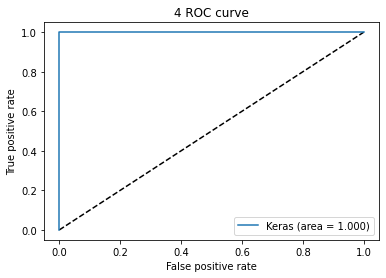

8/8 [==============================] - 0s 48ms/step
[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0] [0.0018565959, 0.13281813, 0.2320456, 1.5303643e-06, 9.668405e-08, 1.0, 2.7288706e-05, 1.0, 1.459427e-08, 1.0, 0.00012684004, 0.010971849, 7.1371556e-07, 0.9999968, 0.99999976, 3.4722487e-07]


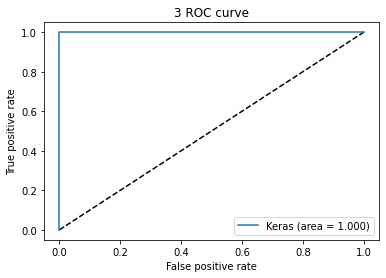

30/30 [==============================] - 1s 48ms/step
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] [5.1159493e-10, 9.806299e-09, 1.0, 1.5777842e-09, 5.649338e-12, 1.932876e-13, 1.9309452e-13, 1.0833821e-05, 0.9999763, 1.0, 2.5125418e-08, 6.0348075e-06, 0.99999917, 0.9999713, 0.00027365095, 0.5451322, 0.0262876, 2.2020544e-05, 0.99999964, 0.00027407552, 0.9997218, 0.9920412, 0.99990225, 0.99999964, 0.99989355, 0.99999535, 6.6265625e-07, 1.0, 5.877347e-10, 0.99999917, 3.99995e-07, 1.0, 1.0, 1.0, 1.0, 0.9998846, 0.9999366, 1.0, 0.99998367, 1.0, 8.0072505e-06, 1.0, 1.0, 0.9999999, 2.5525648e-09, 2.1763789e-11, 3.4968856e-08, 0.9999975, 3.2242852e-08, 4.864891e-08, 0.9999995, 1.0, 0.9999784, 0.00019083645, 0.9999993, 3.8110787e-10, 1.93104

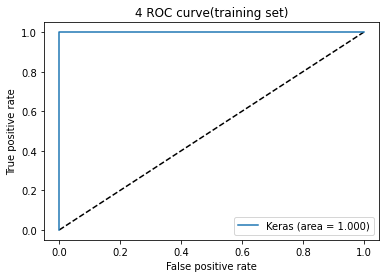

30/30 [==============================] - 1s 48ms/step
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.5859336e-09, 5.50157e-09, 0.99999964, 5.224894e-08, 3.15575e-17, 2.6936506e-09, 7.777758e-14, 2.015063e-09, 1.0, 1.0, 1.2198249e-08, 1.1455784e-06, 0.99999857, 0.99999547, 0.04272467, 0.98994255, 0.9633513, 7.209725e-06, 0.99997914, 7.919778e-06, 0.9979949, 0.9767977, 0.99999285, 1.0, 0.99999976, 1.0, 4.0076777e-08, 1.0, 3.6098557e-09, 1.0, 9.480452e-10, 0.99999976, 1.0, 1.0, 1.0, 0.99999535, 0.99999976, 0.9999999, 0.9999988, 0.99997365, 1.3022769e-08, 1.0, 1.0, 1.0, 3.2668814e-07, 8.26299e-10, 1.6563485e-08, 1.0, 6.818436e-11, 4.3556483e-08, 1.0, 1.0, 0.9999707, 9.500698e-08, 1.0, 4.4893442e-12, 1.4381186e-07, 9.093893e-08, 7.3791034

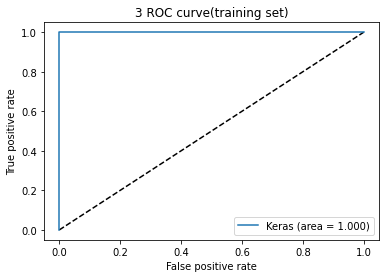

In [134]:
# TO PLOT ROC CURVE
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def to_binary(y_list):
    result = []
    for y in y_list:
        result.append(y[0])
        # if y[0] >= y[1]:
        #     result.append(True)
        # else:
        #     result.append(False)
    return result
f_best_index = four_score.index(min(four_score))
y_pred_keras = four_models[f_best_index].predict([post_test_X, right_test_X, left_test_X, info_test_X], verbose=1, batch_size=num_batch_size)
y_test = to_binary(test_y)
y_pred = to_binary(y_pred_keras)
# y_test = test_y
# y_pred = y_pred_keras
print(y_test, y_pred)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=y_test, y_score=y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('4 ROC curve')
plt.legend(loc='best')
plt.savefig('4roc.pdf')
plt.show()

t_best_index = three_score.index(min(three_score))
y_pred_keras = three_models[t_best_index].predict([post_test_X, right_test_X, left_test_X], verbose=1, batch_size=num_batch_size)
y_test = to_binary(test_y)
y_pred = to_binary(y_pred_keras)
# y_test = test_y
# y_pred = y_pred_keras
print(y_test, y_pred)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=y_test, y_score=y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('3 ROC curve')
plt.legend(loc='best')
plt.savefig('3roc.pdf')
plt.show()

# Training 
f_best_index = four_score.index(min(four_score))
y_pred_keras = four_models[f_best_index].predict([post_train_X, right_train_X, left_train_X, info_train_x], verbose=1, batch_size=num_batch_size)
y_test = to_binary(train_y)
y_pred = to_binary(y_pred_keras)
# y_test = test_y
# y_pred = y_pred_keras
print(y_test, y_pred)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=y_test, y_score=y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('4 ROC curve(training set)')
plt.legend(loc='best')
plt.savefig('4roc_training.pdf')
plt.show()

t_best_index = three_score.index(min(three_score))
y_pred_keras = three_models[t_best_index].predict([post_train_X, right_train_X, left_train_X], verbose=1, batch_size=num_batch_size)
y_test = to_binary(train_y)
y_pred = to_binary(y_pred_keras)
# y_test = test_y
# y_pred = y_pred_keras
print(y_test, y_pred)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=y_test, y_score=y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('3 ROC curve(training set)')
plt.legend(loc='best')
plt.savefig('3roc_training.pdf')
plt.show()

[2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.6335131e-01
 3.1557500e-17]


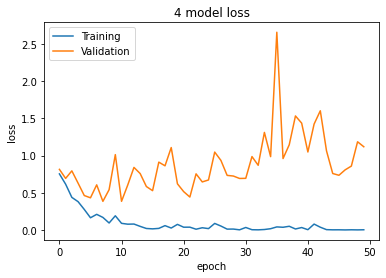

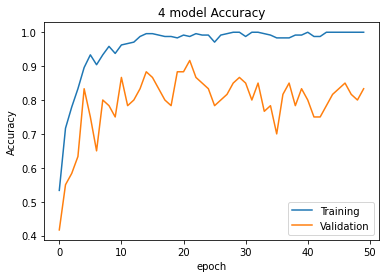

[2.0000000e+00 1.0000000e+00 9.9999988e-01 9.9999976e-01 9.6335131e-01
 3.1557500e-17]


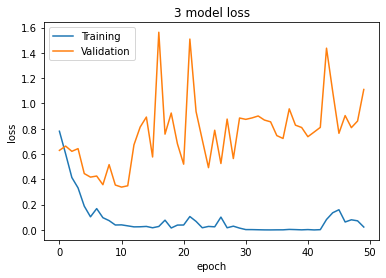

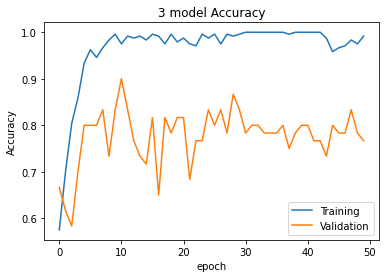

In [135]:
print(thresholds_keras)
lose_average = np.array(four_history_list[0].history["loss"]) / len(four_history_list)
val_loss_average = np.array(four_history_list[0].history["val_loss"]) / len(four_history_list)
acc_average = np.array(four_history_list[0].history["accuracy"]) / len(four_history_list)
val_acc_average = np.array(four_history_list[0].history["val_accuracy"]) / len(four_history_list)

for i in range(1, len(four_history_list)):
    lose_average += np.array(four_history_list[i].history["loss"]) / len(four_history_list)
    val_loss_average += np.array(four_history_list[i].history["val_loss"]) / len(four_history_list)
    acc_average += np.array(four_history_list[i].history["accuracy"]) / len(four_history_list)
    val_acc_average += np.array(four_history_list[i].history["val_accuracy"]) / len(four_history_list)

plt.plot(lose_average[:])
plt.plot(val_loss_average[:])
plt.title('4 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('4loss.pdf')
plt.show()

plt.plot(acc_average[:])
plt.plot(val_acc_average[:])
plt.title('4 model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('4acc.pdf')
plt.show()

print(thresholds_keras)
lose_average = np.array(three_history_list[0].history["loss"]) / len(three_history_list)
val_loss_average = np.array(three_history_list[0].history["val_loss"]) / len(three_history_list)
acc_average = np.array(three_history_list[0].history["accuracy"]) / len(three_history_list)
val_acc_average = np.array(three_history_list[0].history["val_accuracy"]) / len(three_history_list)

for i in range(1, len(three_history_list)):
    lose_average += np.array(three_history_list[i].history["loss"]) / len(three_history_list)
    val_loss_average += np.array(three_history_list[i].history["val_loss"]) / len(three_history_list)
    acc_average += np.array(three_history_list[i].history["accuracy"]) / len(three_history_list)
    val_acc_average += np.array(three_history_list[i].history["val_accuracy"]) / len(three_history_list)

plt.plot(lose_average[:])
plt.plot(val_loss_average[:])
plt.title('3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('3loss.pdf')
plt.show()

plt.plot(acc_average[:])
plt.plot(val_acc_average[:])
plt.title('3 model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('3acc.pdf')
plt.show()

In [136]:
print(four_score[f_best_index])
print(three_score[t_best_index])

[0.21829041838645935, 0.875]
[0.08239148557186127, 0.9375]


30/30 [==============================] - 1s 48ms/step
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0] [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


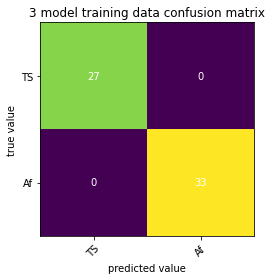

30/30 [==============================] - 1s 49ms/step
[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0] [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


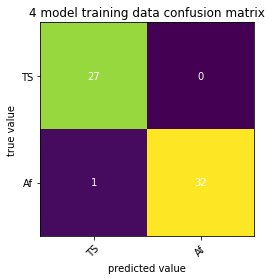

In [137]:
def to_class(y_list):
    result = []
    for y in y_list:
        a = 1
        if y[0] < 0.5:
            a = 0
        result.append(a)
    return result

y_pred_keras = three_models[t_best_index].predict([post_train_X, right_train_X, left_train_X], verbose=1, batch_size=num_batch_size)
y_test = to_class(train_y)
y_pred = to_class(y_pred_keras)
print(y_test, y_pred)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(mat)
# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels(["TS", "Af"])
ax.set_yticklabels(["TS", "Af"])
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")
plt.xlabel("predicted value")
plt.ylabel("true value")
ax.set_title("3 model training data confusion matrix")
fig.tight_layout()
plt.savefig('3_training_matrix.pdf')
plt.show()

y_pred_keras = four_models[f_best_index].predict([post_train_X, right_train_X, left_train_X, info_train_x], verbose=1, batch_size=num_batch_size)
y_test = to_class(train_y)
y_pred = to_class(y_pred_keras)
print(y_test, y_pred)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(mat)
# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels(["TS", "Af"])
ax.set_yticklabels(["TS", "Af"])
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")
plt.xlabel("predicted value")
plt.ylabel("true value")
ax.set_title("4 model training data confusion matrix")
fig.tight_layout()
plt.savefig('4_training_matrix.pdf')
plt.show()

8/8 [==============================] - 0s 47ms/step
[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0] [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]


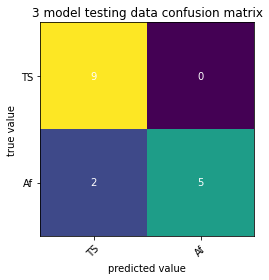

8/8 [==============================] - 0s 48ms/step
[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0] [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]


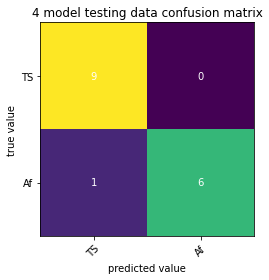

In [140]:
y_pred_keras = three_models[t_best_index].predict([post_test_X, right_test_X, left_test_X], verbose=1, batch_size=num_batch_size)
y_test = to_class(test_y)
y_pred = to_class(y_pred_keras)
print(y_test, y_pred)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(mat)
# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels(["TS", "Af"])
ax.set_yticklabels(["TS", "Af"])
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")
plt.xlabel("predicted value")
plt.ylabel("true value")
ax.set_title("3 model testing data confusion matrix")
fig.tight_layout()
plt.savefig('3_testing_matrix.pdf')
plt.show()

y_pred_keras = four_models[f_best_index].predict([post_test_X, right_test_X, left_test_X, info_test_X], verbose=1, batch_size=num_batch_size)
y_test = to_class(test_y)
y_pred = to_class(y_pred_keras)
print(y_test, y_pred)
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(mat)
# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
ax.set_xticklabels(["TS", "Af"])
ax.set_yticklabels(["TS", "Af"])
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")
plt.xlabel("predicted value")
plt.ylabel("true value")
ax.set_title("4 model testing data confusion matrix")
fig.tight_layout()
plt.savefig('4_testing_matrix.pdf')
plt.show()
# # %%
# lose_average = np.array(four_history_list[f_best_index].history["loss"])
# val_loss_average = np.array(four_history_list[f_best_index].history["val_loss"])
# acc_average = np.array(four_history_list[f_best_index].history["accuracy"])
# val_acc_average = np.array(four_history_list[f_best_index].history["val_accuracy"])

# plt.plot(lose_average[:])
# plt.plot(val_loss_average[:])
# plt.title('4 model best loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(acc_average[:])
# plt.plot(val_acc_average[:])
# plt.title('4 model best Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='lower right')
# plt.show()

# print(thresholds_keras)
# lose_average = np.array(three_history_list[t_best_index].history["loss"])
# val_loss_average = np.array(three_history_list[t_best_index].history["val_loss"])
# acc_average = np.array(three_history_list[t_best_index].history["accuracy"])
# val_acc_average = np.array(three_history_list[t_best_index].history["val_accuracy"])

# plt.plot(lose_average[:])
# plt.plot(val_loss_average[:])
# plt.title('3 model best loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(acc_average[:])
# plt.plot(val_acc_average[:])
# plt.title('3 model best Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='lower right')
# plt.show()